**TRABALHO PRATICO 2** 

**Franci Rrapi (UFMG - 2021/1)**

**2) POTENTIAL FIELD ALGORITHM**

**IMPLEMENTATION and TESTS**

Below is the implementation of this algorithm and you can find also the image tests made (they are also saved and available in the same folder of the notebook)

In [83]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import numpy as np

def Rz(theta):
  
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import matplotlib.patches as patches

WORLDX, WORLDY = 10, 6

In [85]:
# Retorna um vetor com duas colunas: [angulo, dist]
def format_laser_data(range_data, scan_range, step_size, max_sensor_range=5):

    laser_data = []

    range_data = np.asarray(range_data)
    pts = math.floor(scan_range/step_size)
    
    # Rotacionando 90 graus
    angle =- scan_range*0.5
    for i in range(pts):
        
        dist = range_data[i]        
        if dist <= 0:
             dist = max_sensor_range
        
        laser_data.append([angle, dist])
            
        angle=angle+step_size
        
    return np.array(laser_data)
    

Attraction force and repulsion force for more obstacles

In [86]:
def att_force(q, goal, katt=.01):
    return katt*(goal - q)

In [87]:
def rep_force(q, laser_data, R=7, krep=.1):
#     krep = 0.005

    rep_forces = np.array([0,0]) 
    q_rob = np.array([q[0], q[1]])
    qq=np.array([0,0])
        
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        if dist < max_sensor_range:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            q_obs = np.array([x, y])
            
            v = q_rob - q_obs

            rep = (1/dist**2)*((1/dist)-(1/R))*(v/dist) 
            
            rep_forces = rep_forces + rep
    
    return (krep * rep_forces)

In [97]:
####################################################################################
#                                                                                  #
#                             CoppeliaSim needed first!                            #
#                                                                                  #
####################################################################################

print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if clientID!=-1:
    print ('Connected to remote API server')

    # Handle para o ROBÔ    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    
    # Handle para as juntas das RODAS
    returnCode, l_wheel = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, r_wheel = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    returnCode, goalHandle = sim.simxGetObjectHandle(clientID, "Goal", sim.simx_opmode_oneshot_wait)
   
    # Handle para os dados do LASER
    laser_data_name = "hokuyo_range_data"
    
    
    # Geralmente a primeira leitura é inválida (atenção ao Operation Mode)
    # Em loop até garantir que as leituras serão válidas
    returnCode = 1
    while returnCode != 0:
        returnCode, range_data = sim.simxGetStringSignal(clientID, laser_data_name, sim.simx_opmode_streaming + 10)

    path = []
     
    returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    qstart = np.array([pos[0], pos[1], ori[2]])
    
    returnCode, pos = sim.simxGetObjectPosition(clientID, goalHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, ori = sim.simxGetObjectOrientation(clientID, goalHandle, -1, sim.simx_opmode_oneshot_wait)
    
    goal_angle = np.arctan2(pos[1]-qstart[1], pos[0] - qstart[0])
    qgoal = np.array([pos[0], pos[1], goal_angle])
          
    # Frame que representa o Goal
#     returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)     
#     returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qgoal[0], qgoal[1], 0.1638], sim.simx_opmode_oneshot_wait)
#     returnCode = sim.simxSetObjectOrientation(clientID, goalFrame, -1, [0, 0, qgoal[2]], sim.simx_opmode_oneshot_wait)

    
    scan_range = 180*np.pi/180
    step_size = 2*np.pi/1024
    

    max_sensor_range=7
   
    
    # Específico do robô
    # https://www.generationrobots.com/media/Pioneer3DX-P3DX-RevA.pdf
    L = 0.381
    r = 0.0975
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    
    rho = np.inf
    while rho > 0.5:
        
        returnCode, pos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, ori = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        path.append((pos[0],pos[1]))
        robotConfig = np.array([pos[0], pos[1], ori[2]])
        
        
        goal_angle = np.arctan2(qgoal[1]-robotConfig[1], qgoal[0] - robotConfig[0])
        qgoal = np.array([qgoal[0], qgoal[1], goal_angle])
        
        dx, dy = qgoal[:2] - robotConfig[:2]
                     
        # Apenas para interromper o loop
        rho = np.sqrt(dx**2 + dy**2)
                     
        
         # Prosseguindo com as leituras
        returnCode, string_range_data = sim.simxGetStringSignal(clientID, laser_data_name, sim.simx_opmode_oneshot_wait)
        raw_range_data = sim.simxUnpackFloats(string_range_data)
        laser_data = format_laser_data(raw_range_data, scan_range, step_size)
        
        
        Fatt = att_force(robotConfig, qgoal)
    
        Frep = rep_force2(robotConfig,laser_data)
        
        # Total force
        Ft = Fatt + Frep
        
        
#         Ft_x = Ft[:,0]
#         Ft_y = Ft[:,1]
        Ft_x = Ft[0]
        Ft_y = Ft[1]
        
        kr = 1
        kt = 2
        
        v = kr*(Ft_x*np.cos(robotConfig[2]) + Ft_y*np.sin(robotConfig[2]))
        w = kt*(np.arctan2(Ft_x,Ft_y) - robotConfig[2])
                
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)        
        
        vr = ((2.0*v) + (w*L))/(2.0*r)
        vl = ((2.0*v) - (w*L))/(2.0*r)
        
        sim.simxSetJointTargetVelocity(clientID, r_wheel, vr, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, l_wheel, vl, sim.simx_opmode_oneshot_wait)
    
    # Parando o robô    
    sim.simxSetJointTargetVelocity(clientID, r_wheel, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, l_wheel, 0, sim.simx_opmode_oneshot_wait)        
       
    # Parando a simulação     
    sim.simxStopSimulation(clientID,sim.simx_opmode_blocking)         
        
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
else:
    print ('Failed connecting to remote API server')
    
print ('Program ended')

Program started
Connected to remote API server
Program ended


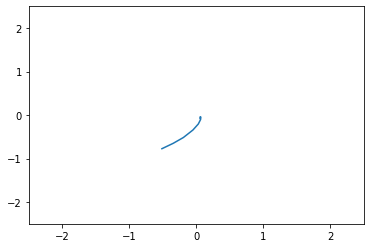

In [96]:
# print(path)
x_val = [x[0] for x in path]
y_val = [x[1] for x in path]

plt.plot(x_val,y_val)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()